## Generator 可以使用 next 來進行循環中的一步
文字上有點難解釋，直接來看範例就能了解什麼是 Generator!

### 撰寫一個 Generator，一次吐出 list 中的一個值

In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [1]:
def output_from_list_generator(your_list):
    for i in your_list:
        yield i 

In [3]:
my_list = [1, 2, 3, 4, 5]

In [4]:
gen = output_from_list_generator(my_list)

In [5]:
print(next(gen))

1


In [6]:
print(next(gen))

2


In [7]:
print(next(gen))

3


In [8]:
print(next(gen))

4


In [9]:
print(next(gen))

5


In [10]:
print(next(gen))

StopIteration: 

### 從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法在得到值

### 我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可

In [11]:
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [12]:
gen = inf_loop_generator(my_list)

In [13]:
print(next(gen))

1


In [14]:
print(next(gen))

2


In [15]:
print(next(gen))

3


In [16]:
print(next(gen))

4


In [17]:
print(next(gen))

5


In [18]:
print(next(gen))

1


In [19]:
print(next(gen))

2


### 上面的程式碼因為我們使用了 While True，所以 for loop 不會結束，只要 call next 就一定會跑一次循環，並返回值

## 雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [20]:
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [21]:
from keras.datasets import cifar10

In [22]:
(x_train, x_test), (y_train, y_test) = cifar10.load_data()

In [23]:
def cifar_generator(image_array, batch_size=32):
    while True:
        for indexs in range(0, len(image_array), batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = x_test[indexs: indexs+batch_size]
            yield images, labels

In [24]:
cifar_gen = cifar_generator(x_train)

In [25]:
images, labels = next(cifar_gen)

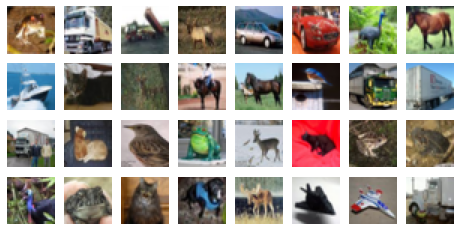

In [26]:
img_combine(images)

In [27]:
images, labels = next(cifar_gen)

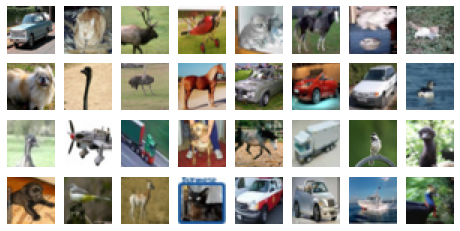

In [28]:
img_combine(images)

## 可以看到兩次的圖片並不一樣，這樣就可以開始訓練囉！

## 作業

請參考昨天的程式碼，將訓練資料讀取方式改寫成 Generator，並將原本的 model.fit 改為 model.fit_generator 來進行訓練。請參考 Keras [官方文件中 fit_generator 的說明](https://keras.io/models/sequential/)

In [45]:
import keras
from keras import Sequential 
from keras.layers import Conv2D ,Activation,MaxPooling2D,Dropout,Flatten,Dense
from sklearn.utils import shuffle

In [30]:
batch_size = 128 
num_classes = 10 
epochs = 10 

In [52]:
def batch_machine(x,y,batch_number):
    while True:
        for num in range(0,len(x),batch_number):
            batch_x = x[num:num+batch_number]
            batch_y = y[num:num+batch_number]
            yield batch_x,batch_y
        x, y = shuffle(x, y)


In [53]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [54]:
ger_train = batch_machine(x_train,y_train,64)

In [55]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit_generator(ger_train,
                    steps_per_epoch=int(len(x_train)/batch_size),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_42 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_43 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 64)       